# DRL Based Self Driving Car Control (Image + Sensor)

## Distributional Reinforcement Learning with Quantile Regression

This notebook is DRL code for the project 'DRL based Self Driving Car Control' <br>
This version uses both **Image data from camera** and **Sensor data from LIDAR** as input

### Import python libraries 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import cv2
import random
import datetime
import os
import time

from unityagents import UnityEnvironment

%matplotlib inline

C:\Users\Q\AppData\Local\Continuum\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Set environment path

Be sure to set `env_name` to the name of the Unity environment file you want to launch.

In [2]:
env_name = "../environment/windows_penalty.exe" # Name of the Unity environment to launch
train_mode = True # Whether to run the environment in training or inference mode

### Start the environment
`UnityEnvironment` launches and begins communication with the environment when instantiated.

Environments contain _brains_ which are responsible for deciding the actions of their associated _agents_. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
env = UnityEnvironment(file_name=env_name)

# Examine environment parameters
print(str(env))

# Set the default brain to work with
default_brain = env.brain_names[0]
brain = env.brains[default_brain]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: Brain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 373
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 5
        Vector Action descriptions: , , , , 


Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: Brain
        Number of Visual Observations (per agent): 1
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 373
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 5
        Vector Action descriptions: , , , , 


### Examine the observation and state spaces
We can reset the environment to be provided with an initial set of observations and states for all the agents within the environment. In ML-Agents, _states_ refer to a vector of variables corresponding to relevant aspects of the environment for an agent. Likewise, _observations_ refer to a set of relevant pixel-wise visuals for an agent.

Sensor data (LIDAR): 
[  1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   1.           1.           1.           1.           1.
   0.9755246    0.91600198   0.86357307   0.81705666   0.77551937
   0.73821479   0.70453942   0.67399871   0.64618438   0.62075633
   0.59742886   0.57596022   0.5561446    0.53780544   0.52079082
   0.50496876   0.49022466   0.47645816   0.46358114   0.45151567
   0.44019303   0.42955208   0.41953811   0.41010255   0.40120158
   0.39279586   0.38485005   0.37733197   0.37021253   0.36346549
   0.35706681   0.35099453   0.34522879   0.33975118   0.33454502
   0.32959491   0.32488668   0.32040724   0.31614468   0.31208783
   0.30822647   0.30455115   0.30105308   0.29772413   0.29455668
   0.29154381   0.288679     0.28595623   0.28336981   0.2809146
   0.27858567   0.27637851   0.27428898   0.27231315   0.27044734
   0.26868826   0.26703268   0.26547778   0.26402083   0.26265934
   0.26139107

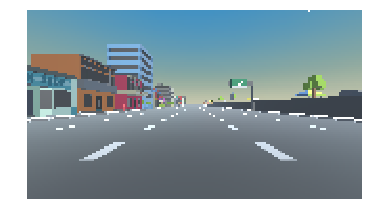

In [4]:
# Reset the environment
env_info = env.reset(train_mode=train_mode)[default_brain]

# Examine the state space for the default brain
print("Sensor data (LIDAR): \n{}".format(env_info.vector_observations[0]))

# Examine the observation space for the default brain
Num_obs = len(env_info.visual_observations)

print("Image data (Front Camera): \n{}")
if Num_obs > 1:
    f, axarr = plt.subplots(1, Num_obs, figsize=(20,10))
    for i, observation in enumerate(env_info.visual_observations):
        if observation.shape[3] == 3:
            axarr[i].imshow(observation[0,:,:,:])
            axarr[i].axis('off')
        else:
            axarr[i].imshow(observation[0,:,:,0])
            axarr[i].axis('off')
else:
    f, axarr = plt.subplots(1, Num_obs)
    for i, observation in enumerate(env_info.visual_observations):
        if observation.shape[3] == 3:
            axarr.imshow(observation[0,:,:,:])
            axarr.axis('off')
        else:
            axarr.imshow(observation[0,:,:,0])
            axarr.axis('off')

### Set Parameters

In [5]:
algorithm = 'QR-DQN'
Num_action = brain.vector_action_space_size

# QR-DQN Parameter
Num_quantile = 50
        
# parameter for DQN
Num_replay_memory = 100000
Num_start_training = 50000
Num_training = 1000000
Num_update = 10000
Num_batch = 32
Num_test = 100000
Num_skipFrame = 4
Num_stackFrame = 4
Num_colorChannel = 1

Epsilon = 1.0
Final_epsilon = 0.1
Gamma = 0.99
Learning_rate = 0.00005

# Parameter for LSTM
Num_dataSize = 366
Num_cellState = 512

# Parameters for network
img_size = 80
sensor_size = 360

first_conv   = [8,8,Num_colorChannel * Num_stackFrame * Num_obs,32]
second_conv  = [4,4,32,64]
third_conv   = [3,3,64,64]
first_dense  = [10*10*64 + Num_cellState, 512]
second_dense = [first_dense[1], Num_action * Num_quantile]

# Path of the network model
load_path = '../saved_networks/2018-09-10_11_20_QR-DQN_both/model.ckpt'

# Parameters for session
Num_plot_episode = 5
Num_step_save = 50000

GPU_fraction = 0.4

### Functions for Networks

In [6]:
# Initialize weights and bias
def weight_variable(shape):
    return tf.Variable(xavier_initializer(shape))

def bias_variable(shape):
	return tf.Variable(xavier_initializer(shape))

# Xavier Weights initializer
def xavier_initializer(shape):
	dim_sum = np.sum(shape)
	if len(shape) == 1:
		dim_sum += 1
	bound = np.sqrt(2.0 / dim_sum)
	return tf.random_uniform(shape, minval=-bound, maxval=bound)

# Convolution function
def conv2d(x,w, stride):
	return tf.nn.conv2d(x,w,strides=[1, stride, stride, 1], padding='SAME')

# Assign network variables to target network
def assign_network_to_target():
	# Get trainable variables
	trainable_variables = tf.trainable_variables()
	# network lstm variables
	trainable_variables_network = [var for var in trainable_variables if var.name.startswith('network')]

	# target lstm variables
	trainable_variables_target = [var for var in trainable_variables if var.name.startswith('target')]

    # assign network variables to target network
	for i in range(len(trainable_variables_network)):
		sess.run(tf.assign(trainable_variables_target[i], trainable_variables_network[i]))

# Code for tensorboard
def setup_summary():
    episode_speed      = tf.Variable(0.)
    episode_overtake   = tf.Variable(0.)
    episode_lanechange = tf.Variable(0.)

    tf.summary.scalar('Average_Speed/' + str(Num_plot_episode) + 'episodes', episode_speed)
    tf.summary.scalar('Average_overtake/' + str(Num_plot_episode) + 'episodes', episode_overtake)
    tf.summary.scalar('Average_lanechange/' + str(Num_plot_episode) + 'episodes', episode_lanechange)

    summary_vars = [episode_speed, episode_overtake, episode_lanechange]
    summary_placeholders = [tf.placeholder(tf.float32) for _ in range(len(summary_vars))]
    update_ops = [summary_vars[i].assign(summary_placeholders[i]) for i in range(len(summary_vars))]
    summary_op = tf.summary.merge_all()
    return summary_placeholders, update_ops, summary_op

### Network

In [7]:
tf.reset_default_graph()

# Input
x_image = tf.placeholder(tf.float32, shape = [None, img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs])
x_normalize = (x_image - (255.0/2)) / (255.0/2)

x_sensor = tf.placeholder(tf.float32, shape = [None, Num_stackFrame, Num_dataSize])
x_unstack = tf.unstack(x_sensor, axis = 1)

with tf.variable_scope('network'):
    # Convolution variables
    w_conv1 = weight_variable(first_conv)
    b_conv1 = bias_variable([first_conv[3]])

    w_conv2 = weight_variable(second_conv)
    b_conv2 = bias_variable([second_conv[3]])

    w_conv3 = weight_variable(third_conv)
    b_conv3 = bias_variable([third_conv[3]])

    # Densely connect layer variables
    w_fc1 = weight_variable(first_dense)
    b_fc1 = bias_variable([first_dense[1]])

    w_fc2 = weight_variable(second_dense)
    b_fc2 = bias_variable([second_dense[1]])
    
    # LSTM cell
    cell = tf.contrib.rnn.BasicLSTMCell(num_units = Num_cellState)            
    rnn_out, rnn_state = tf.nn.static_rnn(inputs = x_unstack, cell = cell, dtype = tf.float32)
    
# Network
h_conv1 = tf.nn.relu(conv2d(x_normalize, w_conv1, 4) + b_conv1)
h_conv2 = tf.nn.relu(conv2d(h_conv1, w_conv2, 2) + b_conv2)
h_conv3 = tf.nn.relu(conv2d(h_conv2, w_conv3, 1) + b_conv3)

h_pool3_flat = tf.reshape(h_conv3, [-1, 10 * 10 * 64])
rnn_out = rnn_out[-1]
h_concat = tf.concat([h_pool3_flat, rnn_out], axis = 1)

h_fc1 = tf.nn.relu(tf.matmul(h_concat, w_fc1)+b_fc1)

# Get Q value for each action
logits = tf.matmul(h_fc1, w_fc2) + b_fc2
logits_reshape = tf.reshape(logits, [-1, Num_action, Num_quantile])
Q_action = tf.reduce_sum(tf.multiply(1/Num_quantile, logits_reshape), axis = 2)

with tf.variable_scope('target'):
    # Convolution variables target
    w_conv1_target = weight_variable(first_conv)
    b_conv1_target = bias_variable([first_conv[3]])

    w_conv2_target = weight_variable(second_conv)
    b_conv2_target = bias_variable([second_conv[3]])

    w_conv3_target = weight_variable(third_conv)
    b_conv3_target = bias_variable([third_conv[3]])

    # Densely connect layer variables target
    w_fc1_target = weight_variable(first_dense)
    b_fc1_target = bias_variable([first_dense[1]])

    w_fc2_target = weight_variable(second_dense)
    b_fc2_target = bias_variable([second_dense[1]])

    # LSTM cell
    cell_target = tf.contrib.rnn.BasicLSTMCell(num_units = Num_cellState)            
    rnn_out_target, rnn_state_target = tf.nn.static_rnn(inputs = x_unstack, cell = cell_target, dtype = tf.float32)
    
# Target Network
h_conv1_target = tf.nn.relu(conv2d(x_normalize, w_conv1_target, 4) + b_conv1_target)
h_conv2_target = tf.nn.relu(conv2d(h_conv1_target, w_conv2_target, 2) + b_conv2_target)
h_conv3_target = tf.nn.relu(conv2d(h_conv2_target, w_conv3_target, 1) + b_conv3_target)

h_pool3_flat_target = tf.reshape(h_conv3_target, [-1, 10 * 10 * 64])
rnn_out_target = rnn_out_target[-1]
h_concat_target = tf.concat([h_pool3_flat_target, rnn_out_target], axis = 1)

h_fc1_target  = tf.nn.relu(tf.matmul(h_concat_target, w_fc1_target)+b_fc1_target)

# Get Q value for each action
logits_target = tf.matmul(h_fc1, w_fc2_target) + b_fc2_target
logits_reshape_target = tf.reshape(logits_target, [-1, Num_action, Num_quantile])
Q_action_target = tf.reduce_sum(tf.multiply(1/Num_quantile, logits_reshape_target), axis = 2)

### Loss and Train

In [8]:
# Loss function and Train
theta_loss = tf.placeholder(tf.float32, shape = [None, Num_quantile])
action_binary_loss = tf.placeholder(tf.float32, shape = [None, Num_action, Num_quantile])

# Get valid logits 
logit_valid = tf.multiply(logits_reshape, action_binary_loss)
logit_valid_nonzero = tf.reduce_sum(logit_valid, axis = 1)

# Stack i and j
theta_loss_tile = tf.tile(tf.expand_dims(theta_loss, axis=2), [1, 1, Num_quantile])
logit_valid_tile = tf.tile(tf.expand_dims(logit_valid_nonzero, axis=1), [1, Num_quantile, 1])

error_loss = theta_loss_tile - logit_valid_tile

# Get Huber loss
Huber_loss = tf.losses.huber_loss(theta_loss_tile, logit_valid_tile, reduction = tf.losses.Reduction.NONE)

# Get tau
min_tau = 1/(2*Num_quantile)
max_tau = (2*(Num_quantile-1)+3)/(2*Num_quantile)
tau = tf.reshape (tf.range(min_tau, max_tau, 1/Num_quantile), [1, Num_quantile])
inv_tau = 1.0 - tau 

# Get Loss
Loss = tf.where(tf.less(error_loss, 0.0), inv_tau * Huber_loss, tau * Huber_loss)
Loss = tf.reduce_mean(tf.reduce_sum(tf.reduce_mean(Loss, axis = 2), axis = 1))

train_step = tf.train.AdamOptimizer(learning_rate = Learning_rate, epsilon = 1e-02/Num_batch).minimize(Loss)

### Config

In [9]:
## Initialize variables
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = GPU_fraction

sess = tf.InteractiveSession(config=config)

init = tf.global_variables_initializer()
sess.run(init)

### Training or Inference

In [10]:
# Load the file if the saved file exists
saver = tf.train.Saver()

# check_save = 1
check_save = input('Inference? / Training?(1=Inference/2=Training): ')

if check_save == '1':
    # Directly start inference
    Num_start_training = 0
    Num_training = 0
    
    # Restore variables from disk.
    saver.restore(sess, load_path)
    print("Model restored.")

# date - hour - minute of training time
date_time = str(datetime.date.today()) + '_' + str(datetime.datetime.now().hour) + '_' + str(datetime.datetime.now().minute)

# Make folder for save data
os.makedirs('../saved_networks/' + date_time + '_' + algorithm + '_both')

# Summary for tensorboard
summary_placeholders, update_ops, summary_op = setup_summary()
summary_writer = tf.summary.FileWriter('../saved_networks/' + date_time + '_' + algorithm + '_both', sess.graph)

Inference? / Training?(1=Inference/2=Training): 2


### Functions for Training

In [11]:
# Initialize input 
def input_initialization(env_info):
    # Observation
    observation_stack_obs = np.zeros([img_size, img_size, Num_colorChannel * Num_obs])
    
    for i in range(Num_obs):
        observation = 255 * env_info.visual_observations[i]
        observation = np.uint8(observation)
        observation = np.reshape(observation, (observation.shape[1], observation.shape[2], 3))
        observation = cv2.resize(observation, (img_size, img_size))

        if Num_colorChannel == 1:
            observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
            observation = np.reshape(observation, (img_size, img_size))

        if Num_colorChannel == 3:
            observation_stack_obs[:,:, Num_colorChannel * i: Num_colorChannel * (i+1)] = observation
        else:
            observation_stack_obs[:,:, i] = observation

    observation_set = []

    # State
    state = env_info.vector_observations[0][:-7]
    state_set = []
        
    for i in range(Num_skipFrame * Num_stackFrame):
        observation_set.append(observation_stack_obs)
        state_set.append(state)
    
    # Stack the frame according to the number of skipping and stacking frames using observation set
    observation_stack = np.zeros((img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs))
    state_stack = np.zeros((Num_stackFrame, Num_dataSize))
    
    for stack_frame in range(Num_stackFrame):
        observation_stack[:,:,Num_obs * stack_frame: Num_obs * (stack_frame+1)] = observation_set[-1 - (Num_skipFrame * stack_frame)]
        state_stack[(Num_stackFrame - 1) - stack_frame, :] = state_set[-1 - (Num_skipFrame * stack_frame)]
    
    observation_stack = np.uint8(observation_stack)
    state_stack = np.uint8(state_stack)
    
    return observation_stack, observation_set, state_stack, state_set

# Resize input information 
def resize_input(env_info, observation_set, state_set):
    # Stack observation according to the number of observations
    observation_stack_obs = np.zeros([img_size, img_size, Num_colorChannel * Num_obs])

    for i in range(Num_obs):
        observation = 255 * env_info.visual_observations[i]
        observation = np.uint8(observation)
        observation = np.reshape(observation, (observation.shape[1], observation.shape[2], 3))
        observation = cv2.resize(observation, (img_size, img_size))
        
        if Num_colorChannel == 1:
            observation = cv2.cvtColor(observation, cv2.COLOR_RGB2GRAY)
            observation = np.reshape(observation, (img_size, img_size))

        if Num_colorChannel == 3:
            observation_stack_obs[:,:, Num_colorChannel * i: Num_colorChannel * (i+1)] = observation
        else:
            observation_stack_obs[:,:,i] = observation
    
    # Add observations to the observation_set
    observation_set.append(observation_stack_obs)
    
    # State 
    state = env_info.vector_observations[0][:-7]

    # Add state to the state_set
    state_set.append(state)
    
    # Stack the frame according to the number of skipping and stacking frames using observation set
    observation_stack = np.zeros((img_size, img_size, Num_colorChannel * Num_stackFrame * Num_obs))
    state_stack = np.zeros((Num_stackFrame, Num_dataSize))

    for stack_frame in range(Num_stackFrame):
        observation_stack[:,:,Num_obs * stack_frame: Num_obs * (stack_frame+1)] = observation_set[-1 - (Num_skipFrame * stack_frame)]
        state_stack[(Num_stackFrame - 1) - stack_frame, :] = state_set[-1 - (Num_skipFrame * stack_frame)]

    del observation_set[0]
    del state_set[0]
    
    observation_stack = np.uint8(observation_stack)
    state_stack = np.uint8(state_stack)
        
    return observation_stack, observation_set, state_stack, state_set

# Get progress according to the number of steps
def get_progress(step, Epsilon):
    if step <= Num_start_training:
        # Observation
        progress = 'Observing'
        train_mode = True
        Epsilon = 1
    elif step <= Num_start_training + Num_training:
        # Training
        progress = 'Training'
        train_mode = True
        
        # Decrease the epsilon value
        if Epsilon > Final_epsilon:
            Epsilon -= 1.0/Num_training
    elif step < Num_start_training + Num_training + Num_test:
        # Testing
        progress = 'Testing'
        train_mode = False
        Epsilon = 0
    else:
        # Finished
        progress = 'Finished'
        train_mode = False
        Epsilon = 0
        
    return progress, train_mode, Epsilon 

# Select action according to the progress of training
def select_action(progress, sess, observation_stack, state_stack, Epsilon):
    if progress == "Observing":
        # Random action 
        Q_value = 0
        action = np.zeros([Num_action])
        action[random.randint(0, Num_action - 1)] = 1.0
    elif progress == "Training":
        # if random value(0-1) is smaller than Epsilon, action is random. 
        # Otherwise, action is the one which has the max Q value
        if random.random() < Epsilon:
            Q_value = 0
            action = np.zeros([Num_action])
            action[random.randint(0, Num_action - 1)] = 1
        else:
            Q_value = Q_action.eval(feed_dict={x_image: [observation_stack], x_sensor: [state_stack]})
            action = np.zeros([Num_action])
            action[np.argmax(Q_value)] = 1
    else:
        # Max Q action 
        Q_value = Q_action.eval(feed_dict={x_image: [observation_stack], x_sensor: [state_stack]})
        action = np.zeros([Num_action])
        action[np.argmax(Q_value)] = 1
        
    return action, Q_value

def train(Replay_memory, sess, step):
    # Select minibatch
    minibatch =  random.sample(Replay_memory, Num_batch)

    # Save the each batch data
    observation_batch      = [batch[0] for batch in minibatch]
    state_batch            = [batch[1] for batch in minibatch]
    action_batch           = [batch[2] for batch in minibatch]
    reward_batch           = [batch[3] for batch in minibatch]
    observation_next_batch = [batch[4] for batch in minibatch]
    state_next_batch       = [batch[5] for batch in minibatch]
    terminal_batch 	       = [batch[6] for batch in minibatch]

    # Update target network according to the Num_update value
    if step % Num_update == 0:
        assign_network_to_target()
    
    
    # Get Target
    Q_batch = Q_action.eval(feed_dict = {x_image: observation_next_batch, x_sensor: state_next_batch})
    theta_batch = logits_reshape_target.eval(feed_dict = {x_image: observation_next_batch, x_sensor: state_next_batch})

    theta_target = []

    for i in range(len(minibatch)):
        theta_target.append([])
        for j in range(Num_quantile):
            if terminal_batch[i] == True:
                theta_target[i].append(reward_batch[i])
            else:
                theta_target[i].append(reward_batch[i] + Gamma * theta_batch[i, np.argmax(Q_batch[i]), j])

    # Calculate action binary
    action_binary = np.zeros([Num_batch, Num_action, Num_quantile])

    for i in range(len(action_batch)):
        action_batch_max = np.argmax(action_batch[i])
        action_binary[i, action_batch_max, :] = 1

    _, loss = sess.run([train_step, Loss],feed_dict = {x_image: observation_batch,
                                                       x_sensor: state_batch,
                                                       theta_loss: theta_target, 
                                                       action_binary_loss: action_binary})

# Experience Replay 
def Experience_Replay(progress, Replay_memory, obs_stack, s_stack, action, reward, next_obs_stack, next_s_stack, terminal):
    if progress != 'Testing':
        # If length of replay memeory is more than the setting value then remove the first one
        if len(Replay_memory) > Num_replay_memory:
            del Replay_memory[0]

        # Save experience to the Replay memory
        Replay_memory.append([obs_stack, s_stack, action, reward, next_obs_stack, next_s_stack, terminal])
    else:
        # Empty the replay memory if testing
        Replay_memory = []
    
    return Replay_memory

### Initialize Variables

In [12]:
# Initial parameters
Replay_memory = []

step = 1
score = 0
score_board = 0

episode = 0
step_per_episode = 0

speed_list = []
overtake_list = []
lanechange_list = []

train_mode = True
env_info = env.reset(train_mode=train_mode)[default_brain]

observation_stack, observation_set, state_stack, state_set = input_initialization(env_info)

### Training

In [13]:
check_plot = 0

# Training & Testing
while True:
   
    # Get Progress, train mode
    progress, train_mode, Epsilon  = get_progress(step, Epsilon)
    
    # Select Actions 
    action, Q_value = select_action(progress, sess, observation_stack, state_stack, Epsilon)
    action_in = [np.argmax(action)]
    
    # Get information for plotting
    vehicle_speed  = 100 * env_info.vector_observations[0][-8]
    num_overtake   = env_info.vector_observations[0][-7]
    num_lanechange = env_info.vector_observations[0][-6]
    
    # Get information for update
    env_info = env.step(action_in)[default_brain]

    next_observation_stack, observation_set, next_state_stack, state_set = resize_input(env_info, observation_set, state_set) 
    reward = env_info.rewards[0]
    terminal = env_info.local_done[0]
    
    if progress == 'Training':
        # Train!! 
        train(Replay_memory, sess, step)

        # Save the variables to disk.
        if step == Num_start_training + Num_training:
            save_path = saver.save(sess, '../saved_networks/' + date_time + '_' + algorithm + '_both' + "/model.ckpt")
            print("Model saved in file: %s" % save_path)
    
    # If progress is finished -> close! 
    if progress == 'Finished':
        print('Finished!!')
        env.close()
        break
        
    Replay_memory = Experience_Replay(progress, 
                                      Replay_memory, 
                                      observation_stack, 
                                      state_stack,
                                      action, 
                                      reward, 
                                      next_observation_stack,
                                      next_state_stack,
                                      terminal)
    
    # Update information
    step += 1
    score += reward
    step_per_episode += 1
    
    observation_stack = next_observation_stack
    state_stack = next_state_stack
    
    # Update tensorboard
    if progress != 'Observing':
        speed_list.append(vehicle_speed)
        
        if episode % Num_plot_episode == 0 and check_plot == 1 and episode != 0:
            avg_speed      = sum(speed_list) / len(speed_list)
            avg_overtake   = sum(overtake_list) / len(overtake_list)
            avg_lanechange = sum(lanechange_list) / len(lanechange_list)
            
            tensorboard_info = [avg_speed, avg_overtake, avg_lanechange]
            for i in range(len(tensorboard_info)):
                sess.run(update_ops[i], feed_dict = {summary_placeholders[i]: float(tensorboard_info[i])})
            summary_str = sess.run(summary_op)
            summary_writer.add_summary(summary_str, step)
            score_board = 0
            
            speed_list = []
            overtake_list = []
            lanechange_list = []

            check_plot = 0
            
    # If terminal is True
    if terminal == True:
        # Print informations
        print('step: ' + str(step) + ' / '  + 'episode: ' + str(episode) + ' / ' + 'progress: ' + progress  + ' / ' + 'epsilon: ' + str(Epsilon)  +' / ' + 'score: ' + str(score))

        check_plot = 1

        if progress != 'Observing':
            episode += 1
            
            score_board += score
            overtake_list.append(num_overtake)
            lanechange_list.append(num_lanechange)
        
            
        score = 0
        step_per_episode = 0

        # Initialize game state
        env_info = env.reset(train_mode=train_mode)[default_brain]
        observation_stack, observation_set, state_stack, state_set = input_initialization(env_info)

        



step: 4716 / episode: 0 / progress: Observing / epsilon: 1 / score: 928.8607370555401
step: 9120 / episode: 0 / progress: Observing / epsilon: 1 / score: 1090.010880857706
step: 14112 / episode: 0 / progress: Observing / epsilon: 1 / score: 215.05138912796974
step: 18900 / episode: 0 / progress: Observing / epsilon: 1 / score: 708.7745587974787
step: 23388 / episode: 0 / progress: Observing / epsilon: 1 / score: 1119.4620645940304
step: 27952 / episode: 0 / progress: Observing / epsilon: 1 / score: 785.8793004900217
step: 32573 / episode: 0 / progress: Observing / epsilon: 1 / score: 662.7685752213001
step: 34907 / episode: 0 / progress: Observing / epsilon: 1 / score: 413.81883031129837
step: 37344 / episode: 0 / progress: Observing / epsilon: 1 / score: 563.0496207028627
step: 42144 / episode: 0 / progress: Observing / epsilon: 1 / score: 570.8713311702013
step: 46814 / episode: 0 / progress: Observing / epsilon: 1 / score: 966.4257670640945
step: 51361 / episode: 0 / progress: Train

step: 263473 / episode: 69 / progress: Training / epsilon: 0.7865279999938615 / score: 1410.3379526883364
step: 267418 / episode: 70 / progress: Training / epsilon: 0.782582999993748 / score: 1746.6719843447208
step: 268185 / episode: 71 / progress: Training / epsilon: 0.781815999993726 / score: 302.1650262326002
step: 272645 / episode: 72 / progress: Training / epsilon: 0.7773559999935977 / score: 904.4200411438942
step: 274287 / episode: 73 / progress: Training / epsilon: 0.7757139999935505 / score: 728.755104586482
step: 278864 / episode: 74 / progress: Training / epsilon: 0.7711369999934189 / score: 766.6310531944036
step: 279634 / episode: 75 / progress: Training / epsilon: 0.7703669999933968 / score: 215.79902900755405
step: 283048 / episode: 76 / progress: Training / epsilon: 0.7669529999932986 / score: 967.6565200686455
step: 287402 / episode: 77 / progress: Training / epsilon: 0.7625989999931734 / score: 978.034416615963
step: 287725 / episode: 78 / progress: Training / epsilo

step: 496303 / episode: 147 / progress: Training / epsilon: 0.5536979999871663 / score: 1046.8435120284557
step: 498231 / episode: 148 / progress: Training / epsilon: 0.5517699999871108 / score: 580.312436491251
step: 502025 / episode: 149 / progress: Training / epsilon: 0.5479759999870017 / score: 2086.7180997878313
step: 505914 / episode: 150 / progress: Training / epsilon: 0.5440869999868899 / score: 1979.537411302328
step: 510027 / episode: 151 / progress: Training / epsilon: 0.5399739999867716 / score: 1547.7134614735842
step: 511999 / episode: 152 / progress: Training / epsilon: 0.5380019999867149 / score: 1165.4174547195435
step: 513395 / episode: 153 / progress: Training / epsilon: 0.5366059999866748 / score: 603.7891589552164
step: 517247 / episode: 154 / progress: Training / epsilon: 0.532753999986564 / score: 2008.683905556798
step: 518822 / episode: 155 / progress: Training / epsilon: 0.5311789999865187 / score: 701.0136257261038
step: 521820 / episode: 156 / progress: Trai

step: 728988 / episode: 224 / progress: Training / epsilon: 0.3210129999904111 / score: 2714.3598853498697
step: 732628 / episode: 225 / progress: Training / epsilon: 0.3173729999905085 / score: 2440.4368229210377
step: 736584 / episode: 226 / progress: Training / epsilon: 0.31341699999061434 / score: 2128.4409288167953
step: 738157 / episode: 227 / progress: Training / epsilon: 0.31184399999065643 / score: 917.7157562971115
step: 741935 / episode: 228 / progress: Training / epsilon: 0.3080659999907575 / score: 2276.4101743102074
step: 744569 / episode: 229 / progress: Training / epsilon: 0.305431999990828 / score: 1191.4638617634773
step: 746057 / episode: 230 / progress: Training / epsilon: 0.3039439999908678 / score: 745.2543102055788
step: 749948 / episode: 231 / progress: Training / epsilon: 0.3000529999909719 / score: 2094.570143312216
step: 751483 / episode: 232 / progress: Training / epsilon: 0.29851799999101297 / score: 878.9694866091013
step: 755719 / episode: 233 / progress:

step: 943944 / episode: 301 / progress: Training / epsilon: 0.10605699999216711 / score: 2729.2090810239315
step: 945341 / episode: 302 / progress: Training / epsilon: 0.10465999999216571 / score: 1243.4559264183044
step: 949454 / episode: 303 / progress: Training / epsilon: 0.1005469999921616 / score: 2151.6312170624733
step: 952891 / episode: 304 / progress: Training / epsilon: 0.09999999999216105 / score: 2888.0221408605576
step: 956564 / episode: 305 / progress: Training / epsilon: 0.09999999999216105 / score: 2532.2987395823
step: 958593 / episode: 306 / progress: Training / epsilon: 0.09999999999216105 / score: 1676.8678030222654
step: 962660 / episode: 307 / progress: Training / epsilon: 0.09999999999216105 / score: 2179.5906291157007
step: 963843 / episode: 308 / progress: Training / epsilon: 0.09999999999216105 / score: 801.9914474487305
step: 967275 / episode: 309 / progress: Training / epsilon: 0.09999999999216105 / score: 2938.538444623351
step: 971242 / episode: 310 / prog

In [14]:
env.close()